In [41]:
import pandas as pd
import numpy as np
from node2vec import Node2Vec
#from torch_geometric.nn import Node2Vec
from collections import defaultdict
from itertools import combinations
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from utils import *


## Country borders (land)

In [58]:
G = parse_country_neighbors(f"{data_paths['additional']}/4.4 Country Borders.txt")

In [59]:
for i in nx.connected_components(G):
    print(i)

{'RWA', 'GMB', 'RUS', 'BEL', 'KOR', 'LTU', 'PAK', 'LVA', 'ZWE', 'ESH', 'TUN', 'BDI', 'MYS', 'XKX', 'BEN', 'GRC', 'MLI', 'TLS', 'KHM', 'SVN', 'BGD', 'QAT', 'LAO', 'CHN', 'IRN', 'SOM', 'ESP', 'AGO', 'CHE', 'BIH', 'DJI', 'KEN', 'SCG', 'LSO', 'MOZ', 'CAF', 'DZA', 'LBY', 'ETH', 'ARE', 'BGR', 'BWA', 'PNG', 'ZAF', 'EGY', 'SVK', 'GEO', 'DEU', 'GIN', 'COD', 'MCO', 'SRB', 'ERI', 'IND', 'TCD', 'CIV', 'CMR', 'LBR', 'BFA', 'CZE', 'PRK', 'MKD', 'UKR', 'MAR', 'SYR', 'TZA', 'NER', 'NPL', 'THA', 'NLD', 'LIE', 'AZE', 'UGA', 'GNB', 'MWI', 'NOR', 'TKM', 'TUR', 'LBN', 'SWE', 'YEM', 'MMR', 'BRN', 'DNK', 'SWZ', 'ITA', 'IRQ', 'NGA', 'AFG', 'OMN', 'JOR', 'VAT', 'SMR', 'EST', 'KAZ', 'HRV', 'UZB', 'VNM', 'FIN', 'TJK', 'SAU', 'ALB', 'HUN', 'AUT', 'GAB', 'MDA', 'ISR', 'SDN', 'MNG', 'MRT', 'GNQ', 'LUX', 'ROU', 'KWT', 'POL', 'SSD', 'MNE', 'NAM', 'SEN', 'ARM', 'BTN', 'COG', 'KGZ', 'IDN', 'PSE', 'PRT', 'FRA', 'AND', 'ZMB', 'GHA', 'BLR', 'SLE', 'TGO', 'GIB'}
{'NIC', 'GTM', 'MEX', 'BLZ', 'SUR', 'BRA', 'SLV', 'URY', 'VEN

## Country borders (maritime)

In [45]:
maritime = pd.read_excel(f"{data_paths['additional']}/4.5 CERDI-seadistance.xlsx")[["iso1", "iso2", "seadistance"]]
maritime = maritime[maritime.seadistance > 0]

In [46]:
maritime.loc[:, "weights"] = maritime_distance_to_weight(maritime.loc[:, "seadistance"])

In [48]:
maritime.head()

,iso1,iso2,seadistance,weights
0,ABW,AFG,16498.800,0.184838
1,ABW,AGO,9437.060,0.533740
2,ABW,AIA,956.853,0.952724
3,ABW,ALB,8790.060,0.565706
4,ABW,AND,7685.420,0.620284


In [49]:
maritime.describe()

,seadistance,weights
count,51170.000000,51170.000000
mean,10509.142872,0.482378
std,5412.223768,0.264338
min,2.803440,0.010000
25%,6593.160000,0.268229
50%,10014.600000,0.505205
75%,14810.975000,0.674249
max,23710.900000,0.999861


In [50]:
already_added = set()
for ix, row in maritime.iterrows():
    # The edge from maritime distances
    edge = (min(row["iso1"], row["iso2"]), max(row["iso1"], row["iso2"]))
    # If already added, skip
    if edge in already_added:
        continue
    # If not added, and not a border country, add it
    elif not G.has_edge(row["iso1"], row["iso2"]):
        G.add_edge(row["iso1"], row["iso2"], weight=row["weights"])
    # If already a border country, but also a maritime connection, add to the weight
    else:
        G[row["iso1"]][row["iso2"]]["weight"] += row["weights"]
    already_added.add(edge)

In [51]:
for i in nx.connected_components(G):
    print(i)

{'DOM', 'DMA', 'PYF', 'RWA', 'GMB', 'RUS', 'BEL', 'KOR', 'LTU', 'PAK', 'LVA', 'ZWE', 'FRO', 'ESH', 'TUN', 'TON', 'BRA', 'BDI', 'MYS', 'XKX', 'BEN', 'SLV', 'CYP', 'AIA', 'NCL', 'VUT', 'GUY', 'STP', 'GRC', 'CAN', 'BOL', 'GRL', 'MLI', 'MTQ', 'TLS', 'COL', 'KHM', 'SVN', 'BGD', 'QAT', 'LAO', 'CHN', 'MHL', 'PRY', 'IRN', 'SOM', 'TTO', 'ESP', 'FJI', 'AGO', 'USA', 'BIH', 'DJI', 'KEN', 'CHE', 'BRB', 'CPV', 'NIU', 'WSM', 'GTM', 'GRD', 'SCG', 'GBR', 'FLK', 'NRU', 'LSO', 'BMU', 'MOZ', 'CAF', 'PLW', 'DZA', 'LBY', 'LCA', 'ARE', 'ETH', 'PHL', 'BLZ', 'COM', 'SUR', 'BGR', 'BWA', 'PNG', 'TKL', 'ZAF', 'EGY', 'IRL', 'ISL', 'KNA', 'GEO', 'SVK', 'DEU', 'VCT', 'GIN', 'COD', 'MCO', 'PER', 'CUB', 'SRB', 'ERI', 'IND', 'GLP', 'MYT', 'CIV', 'CMR', 'LBR', 'TCD', 'BFA', 'SLB', 'CZE', 'PRK', 'MKD', 'ARG', 'CRI', 'UKR', 'KIR', 'SPM', 'NFK', 'MAR', 'SYR', 'TZA', 'NER', 'NZL', 'NIC', 'NPL', 'THA', 'TWN', 'NLD', 'JPN', 'TUV', 'HTI', 'FSM', 'LIE', 'AZE', 'CYM', 'UGA', 'ANT', 'GNB', 'AUS', 'ABW', 'MWI', 'NOR', 'TKM', 'LBN'

In [61]:
G["COD"]["CAF"]

{'weight': 1}

In [53]:
largest_cc = max(nx.connected_components(G), key=len)
nx.diameter(G.subgraph(largest_cc).copy())

3

In [54]:
# Node2Vec 
node2vec = Node2Vec(G, dimensions=8, walk_length=10, num_walks=200, p=1, q=1, weight_key='weight', workers=4)
model = node2vec.fit(window=4, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 234/234 [00:18<00:00, 12.62it/s]


In [55]:
model.wv['ARG']  # get embedding for a country
model.wv.most_similar('COD', topn=20)  # find nearest countries
#model.wv.save_word2vec_format('geo-embeddings.vec')  # save

[('CAF', 0.9752538204193115),
 ('AGO', 0.9004557132720947),
 ('COG', 0.8941428065299988),
 ('NAM', 0.8810034990310669),
 ('CMR', 0.8743130564689636),
 ('TCD', 0.8738909959793091),
 ('GAB', 0.8699572086334229),
 ('SHN', 0.8638170957565308),
 ('GHA', 0.8614054918289185),
 ('NER', 0.8554769158363342),
 ('BEN', 0.8450550436973572),
 ('GNQ', 0.8382112383842468),
 ('BFA', 0.8350257277488708),
 ('NGA', 0.8298065662384033),
 ('LBR', 0.8279633522033691),
 ('TGO', 0.801110565662384),
 ('STP', 0.7985994219779968),
 ('CIV', 0.7931327223777771),
 ('SSD', 0.7330167293548584),
 ('MLI', 0.7222533226013184)]

## Visualization

Note on UMAP Reproducibility <br>
(https://umap-learn.readthedocs.io/en/latest/reproducibility.html) <br>
UMAP is a stochastic algorithm – it makes use of randomness both to speed up approximation steps, and to aid in solving hard optimization problems. This means that different runs of UMAP can produce different results. UMAP is relatively stable – thus the variance between runs should ideally be relatively small – but different runs may have variations none the less. To ensure that results can be reproduced exactly UMAP allows the user to set a random seed state. <br>

Since version 0.4 UMAP also support multi-threading for faster performance; when performing optimization this exploits the fact that race conditions between the threads are acceptable within certain optimization phases. Unfortunately this means that the randomness in UMAP outputs for the multi-threaded case depends not only on the random seed input, but also on race conditions between threads during optimization, over which no control can be had. This means that multi-threaded UMAP results cannot be explicitly reproduced.

In [62]:
# Get list of country names and their vectors
countries = list(model.wv.vocab.keys())
vectors = np.array([model.wv[c] for c in countries])

reducer = umap.UMAP(n_neighbors=5, min_dist=0.9)
vectors_2d = reducer.fit_transform(vectors)

c:\Users\ginof\anaconda3\envs\thesis\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


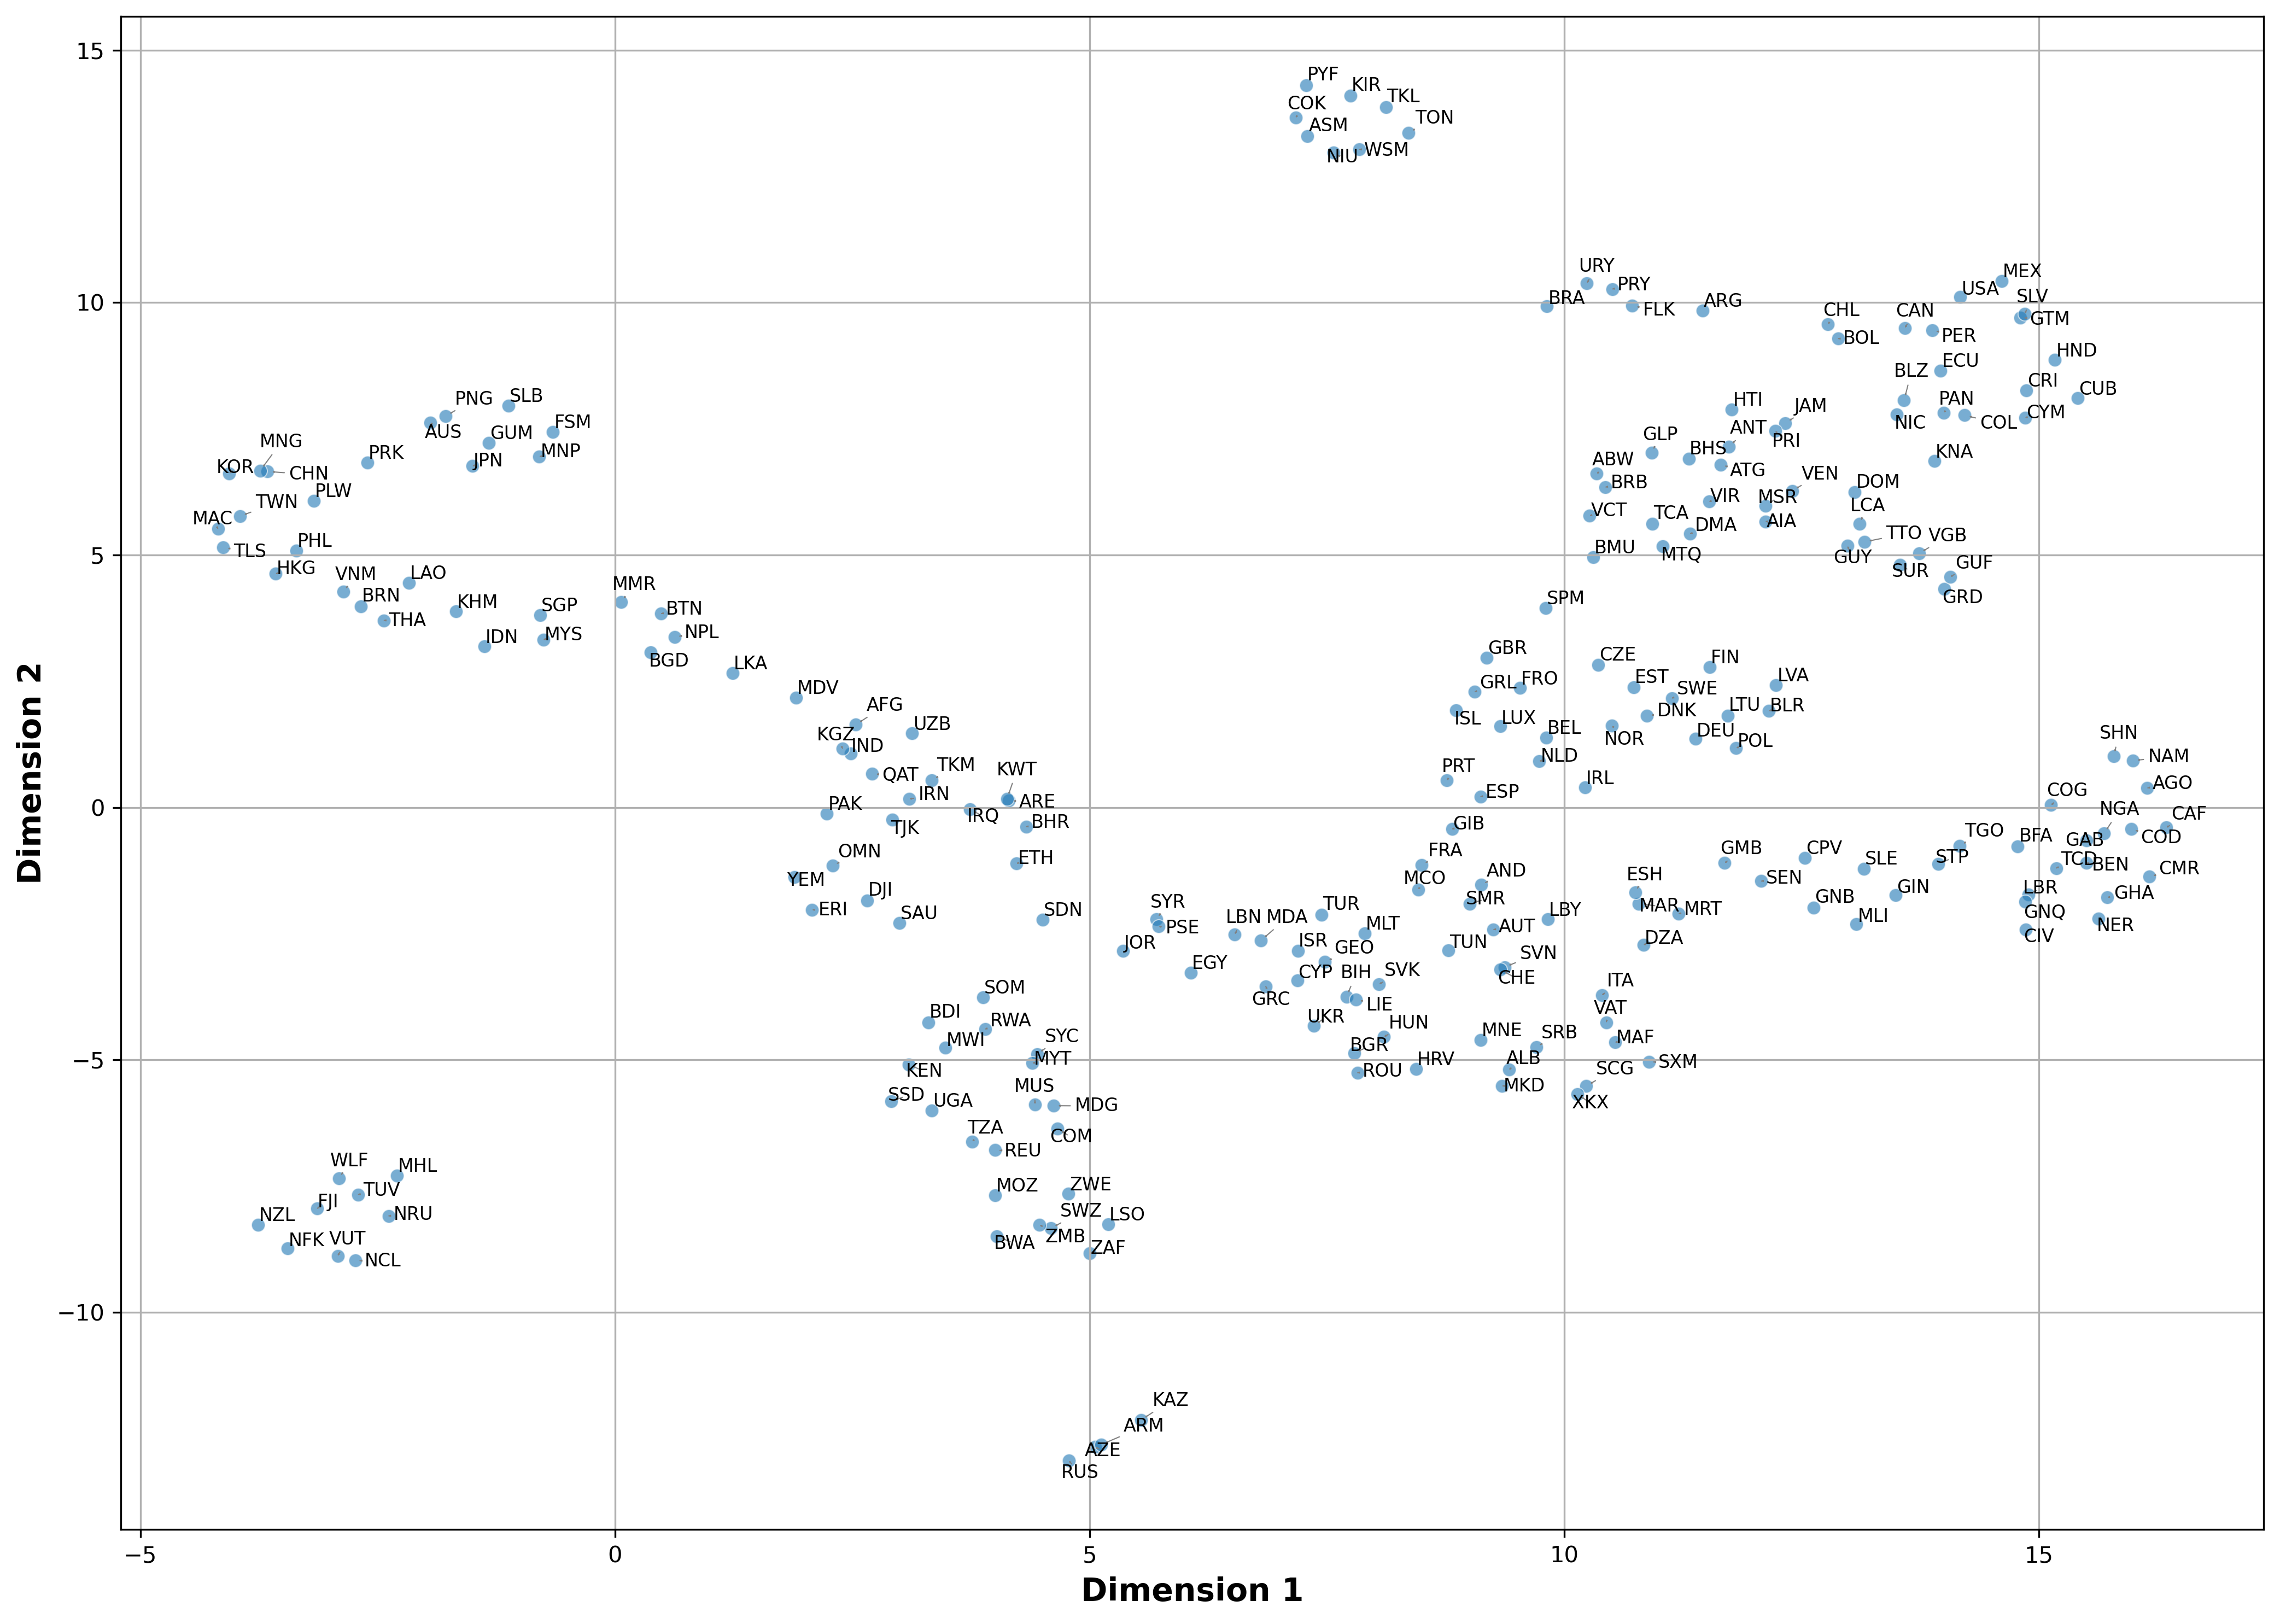

In [63]:
fig, ax = plt.subplots(figsize=(14, 10), dpi=300)

sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1], alpha=0.6, ax=ax)

# Create all text labels
texts = [
    plt.text(vectors_2d[i, 0], vectors_2d[i, 1], country, fontsize=8)
    for i, country in enumerate(countries)
]

plt.xlabel("Dimension 1", fontsize=14, fontweight='bold')
plt.ylabel("Dimension 2", fontsize=14, fontweight='bold')
plt.grid(True)
plt.tight_layout()
# Auto-adjust to avoid overlap
#adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5), ax=ax, expand_axes=True)
adjust_text(texts, #expand=(2, 2), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), # ensure the labeling is clear by adding arrows
            force_text=(3, 3));
plt.show()


### Trading agreements

In [65]:
trading_agreements = pd.read_excel(f"{data_paths['additional']}/4.1. Trading agreements.xlsx")

In [66]:
trading_agreements["In-force Status"].unique()

array(['in force', 'unknown', 'expired', nan, 'signed - not yet in force'],
      dtype=object)

In [67]:
trading_agreements = trading_agreements[trading_agreements["In-force Status"] == 'in force']

In [68]:
trading_agreements["Date of Signature"] = pd.to_datetime(trading_agreements["Date of Signature"], format="%d %b %Y")
trading_agreements["Date of Entry into Force"] = pd.to_datetime(trading_agreements["Date of Entry into Force"], format="%d %b %Y")

In [69]:
trading_agreements[trading_agreements["Date of Entry into Force"] > pd.to_datetime("2012-01-01")]

,Common Name,Membership,Type of Agreement,Date of Signature,Date of Entry into Force,Notified to WTO,In-force Status


In [70]:
trading_agreements.Membership.str.split(";")

0      [Algeria, Angola, Benin, Botswana, Burkina Fas...
1                                   [Afghanistan, India]
2                                   [Afghanistan, India]
8                                     [Albania, Türkiye]
12     [Bolivia (Plurinational State of), Colombia, E...
                             ...                        
344                     [United States of America, Oman]
345                     [United States of America, Peru]
346                [United States of America, Singapore]
347                 [United States of America, Viet Nam]
348    [Benin, Burkina Faso, Cote d'Ivoire, Mali, Nig...
Name: Membership, Length: 254, dtype: object

In [71]:
countries_map = pd.read_csv(f"{data_paths['atlas']}/countries.csv", encoding="latin1")

In [72]:
# Initialize a dict for edge weights
edge_weights = defaultdict(int)

# Iterate over each agreement
for row in trading_agreements.Membership:  # in case of NaNs
    countries = [c.strip() for c in row.split(';')]
    # Add edges for each pair (undirected)
    for c1, c2 in combinations(sorted(countries), 2):
        edge_weights[(c1, c2)] += 1

In [73]:
edge_weights

defaultdict(int,
            {('Algeria', 'Angola'): 1,
             ('Algeria', 'Benin'): 2,
             ('Algeria', 'Botswana'): 1,
             ('Algeria', 'Burkina Faso'): 1,
             ('Algeria', 'Burundi'): 1,
             ('Algeria', 'Cabo Verde'): 1,
             ('Algeria', 'Cameroon'): 2,
             ('Algeria', 'Central African Republic'): 1,
             ('Algeria', 'Chad'): 1,
             ('Algeria', 'Comoros'): 1,
             ('Algeria', 'Congo'): 1,
             ('Algeria', "Cote d'Ivoire"): 1,
             ('Algeria', 'Djibouti'): 1,
             ('Algeria', 'Egypt'): 3,
             ('Algeria', 'Equatorial Guinea'): 1,
             ('Algeria', 'Ethiopia'): 1,
             ('Algeria', 'Gabon'): 1,
             ('Algeria', 'Gambia'): 1,
             ('Algeria', 'Ghana'): 2,
             ('Algeria', 'Guinea'): 2,
             ('Algeria', 'Guinea-Bissau'): 1,
             ('Algeria', 'Kenya'): 1,
             ('Algeria', 'Lesotho'): 1,
             ('Algeria', 'Libe

In [74]:
trading_agreements = pd.DataFrame(edge_weights.items(), columns=["pair", "weight"])
trading_agreements[["src", "tgt"]] = trading_agreements.pair.apply(pd.Series)
trading_agreements.drop("pair", axis=1, inplace=True) 

Make it both ways

In [75]:
trading_agreements_ = trading_agreements.copy()
trading_agreements_.rename({"src": "tgt", "tgt": "src"}, axis=1, inplace=True)

In [76]:
trading_agreements = pd.concat([trading_agreements, trading_agreements_], axis=0, ignore_index=True)

In [77]:
trading_agreements = trading_agreements.merge(countries_map[["country", "country_id"]], right_on="country", left_on="src", how="left")
trading_agreements.drop(["country", "src"], axis=1, inplace=True)
trading_agreements.rename({"country_id": "src"}, axis=1, inplace=True)

In [78]:
trading_agreements = trading_agreements.merge(countries_map[["country", "country_id"]], right_on="country", left_on="tgt", how="left")
trading_agreements.drop(["country", "tgt"], axis=1, inplace=True)
trading_agreements.rename({"country_id": "tgt"}, axis=1, inplace=True)

In [79]:
trading_agreements.head()

,weight,src,tgt
0,1,12,24
1,2,12,204
2,1,12,72
3,1,12,854
4,1,12,108


In [ ]:
#trading_agreements.to_csv("trading_agreements_edges.csv", index=False)